<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Manually_Hard_Coding_OLS_%26_NN_1_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Episod70t. Transfer Learning for Task Similarity (within industry effect)

## Step 1. Setup & Load Data

In [1]:
# prompt: gdrive connect

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#--- 설정 -------------------------------------------------
PATH = '/content/drive/MyDrive/Colab Notebooks/ep70tf_TransferLearning_JH_edit.ipynb'  # ← 본인 경로
#----------------------------------------------------------

import nbformat, json, pathlib, sys
from nbformat.validator import validate, ValidationError

def strip_widgets(obj):
    """dict 안에서 metadata.widgets 키를 전부 제거 (재귀)"""
    if isinstance(obj, dict):
        obj.pop('widgets', None)
        for v in obj.values():
            strip_widgets(v)
    elif isinstance(obj, list):
        for item in obj:
            strip_widgets(item)

nb = nbformat.read(PATH, as_version=nbformat.NO_CONVERT)

# 1) 노트북 전체(루트)에서 제거
nb.metadata.pop('widgets', None)
# 2) 각 셀 및 하위 metadata에서 제거
strip_widgets(nb.cells)

nbformat.write(nb, PATH)
print("👉 widgets 메타데이터 제거 완료")

# --- 유효성 검증 (GitHub 미리보기와 같은 도구가 통과할지 확인) ---
try:
    validate(nb)         # nbformat 내장 검증기
    print("✅ nbformat validate 통과 – 정상 파일입니다.")
except ValidationError as e:
    print("❌ 여전히 문제:", e)


👉 widgets 메타데이터 제거 완료
✅ nbformat validate 통과 – 정상 파일입니다.


In [3]:
# import libraries
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
# read data into pandas DataFrame
df_raw = pd.read_csv("/content/drive/MyDrive/CompA2019_inputdata2.csv")

In [6]:
# fewer input variables
# df = df[["ff17","logq_f","lat_f","capx2a_f","che2a_f","cogs2a_f","dlc2a_f","dltt2a_f","emp2a_f","invt2a_f","ni2a_f","ppent2a_f","re2a_f","txt2a_f","xad2a_f","xint2a_f","xrd2a_f","xsga2a_f"]]
#df = df[["ff17","logq_f","lat_f","capx2a_f","dlc2a_f","dltt2a_f","emp2a_f","ppent2a_f","xad2a_f","xrd2a_f"]]
df = df_raw[[
    "ff17",      # 산업 코드 (Fama–French 17) ─ 산업 구분용
    "logq_f",    # 로그 Tobin’s Q ─ 목표값(y)
    "lat_f",     # 총자산 로그 ─ 규모 지표
    "capx2a_f",  # 설비투자/자산
    "che2a_f",   # 현금·현금성/자산
    "cogs2a_f",  # 매출원가/자산
    "dlc2a_f",   # 단기부채/자산
    "dltt2a_f",  # 장기부채/자산
    "emp2a_f",   # 종업원수/자산
    "invt2a_f",  # 재고/자산
    "ni2a_f",    # 순이익/자산
    "ppent2a_f", # 유형자산(설비)/자산
    "re2a_f",    # 이익잉여금/자산
    "txt2a_f",   # 법인세비용/자산
    "xad2a_f",   # 광고비/자산
    "xint2a_f",  # 이자비용/자산
    "xrd2a_f",   # R&D/자산
    "xsga2a_f"   # 판매·관리비/자산
]].copy()

x_cols = [col for col in df.columns if col not in ['ff17', 'logq_f']]

for col in df.columns:
    if col != 'ff17': # Don't convert the grouping column
        print(f"Checking type of column '{col}': {type(df[col])}") # Added print for debugging
        df[col] = pd.to_numeric(df[col], errors='coerce')


Checking type of column 'logq_f': <class 'pandas.core.series.Series'>
Checking type of column 'lat_f': <class 'pandas.core.series.Series'>
Checking type of column 'capx2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'che2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'cogs2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'dlc2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'dltt2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'emp2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'invt2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'ni2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'ppent2a_f': <class 'pandas.core.series.Series'>
Checking type of column 're2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'txt2a_f': <class 'pandas.core.series.Series'>
Checking type of column 'xad2a_f': <class 'pandas.core.series.Series'>
Check

# 1. OLS Regression with library

In [7]:
import statsmodels.api as sm
import pandas as pd

# Group by industry code 'ff17'
grouped = df.groupby('ff17')

# Get independent variable names (exclude target and group key)


# Initialize a dictionary to store regression results
regression_results = {
    'beta': {},
    'R-squared': {},
    'p-value': {},
    't-value': {}
}

# Run regression for each industry
for industry, group_df in grouped:
    y = group_df['logq_f']
    X = sm.add_constant(group_df[x_cols])  # add intercept
    model = sm.OLS(y, X)
    results = model.fit()
    regression_results['beta'][industry] = results.params.to_dict()
    regression_results['R-squared'][industry] = results.rsquared
    regression_results['p-value'][industry] = results.pvalues.to_dict()
    regression_results['t-value'][industry] = results.tvalues.to_dict()

# Convert results to DataFrames
beta_df = pd.DataFrame(regression_results['beta']).T
r2_df = pd.Series(regression_results['R-squared'], name='R-squared')
pval_df = pd.DataFrame(regression_results['p-value']).T
tval_df = pd.DataFrame(regression_results['t-value']).T
# Round values and format strings
beta_df_rounded = beta_df.round(3)
tval_df_formatted = tval_df.applymap(lambda x: f"({x:.2f})")

# Generate significance stars based on p-values
def get_significance(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    return ''

significance_df = pval_df.applymap(get_significance)

# Create a MultiIndex for the rows: (variable, stat)
variables = beta_df.columns
multi_rows = pd.MultiIndex.from_product(
    [variables, ['beta', 't-value', 'significance']],
    names=['Variable', 'Stat']
)

# Combine rows into a final list
rows = []
for var in variables:
    rows.append(beta_df_rounded[var])       # beta
    rows.append(tval_df_formatted[var])     # t-value
    rows.append(significance_df[var])       # significance stars

# Create the final table
final_df = pd.DataFrame(rows, index=multi_rows)
print(r2_df)
# Display or export
final_df
# final_df.to_excel("regression_table_with_significance.xlsx")


1     0.514295
2     0.447777
3     0.347769
4     0.622697
5     0.518355
6     0.691219
7     0.298215
8     0.551379
9     0.614698
10    0.961670
11    0.272986
12    0.730801
13    0.558256
14    0.516009
15    0.575898
16    0.338698
17    0.243104
Name: R-squared, dtype: float64


/tmp/ipython-input-7-2986646683.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tval_df_formatted = tval_df.applymap(lambda x: f"({x:.2f})")
/tmp/ipython-input-7-2986646683.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significance_df = pval_df.applymap(get_significance)


1        2        3        4        5        6   \
Variable  Stat                                                                 
const     beta              0.0      0.0     -0.0     -0.0     -0.0     -0.0   
          t-value        (0.00)   (0.00)  (-0.00)  (-0.00)  (-0.00)  (-0.00)   
          significance                                                         
lat_f     beta            0.049    0.044    0.008   -0.013    0.041   -0.089   
          t-value        (1.29)   (1.54)   (0.50)  (-0.12)   (0.65)  (-1.92)   
          significance                                                     *   
capx2a_f  beta            0.458    0.454    0.219    1.952    1.823   -0.286   
          t-value        (1.49)   (4.01)   (3.86)   (1.03)   (2.36)  (-0.62)   
          significance               ***      ***                **            
che2a_f   beta            0.619    0.186    0.174    0.179    0.043    0.139   
          t-value        (4.79)   (2.74)   (2.82)   (0.65)   (0.36)   (1.05)   
          significance      ***      ***      ***                              
cogs2a_f  beta            0.034   -0.019    0.003    0.018   -0.045   -0.049   
          t-value        (1.50)  (-0.61)   (0.26)   (0.18)  (-0.90)  (-1.23)   
          significance                                                         
dlc2a_f   beta            0.165    0.071    0.159    0.401   -0.134    1.357   
          t-value        (1.35)   (1.66)   (3.87)   (1.09)  (-0.70)   (4.97)   
          significance                 *      ***                        ***   
dltt2a_f  beta            0.014    0.071    0.128    0.185   -0.115    0.456   
          t-value        (0.17)   (1.18)   (3.66)   (0.65)  (-0.85)   (4.19)   
          significance                        ***                        ***   
emp2a_f   beta           -3.755  -13.711  -17.216   -1.373  -11.252  -10.497   
          t-value       (-0.64)  (-2.11)  (-2.90)  (-0.39)  (-1.68)  (-0.39)   
          significance                **      ***                 *            
invt2a_f  beta           -0.035   -0.117   -0.275    0.078    -0.36   -0.622   
          t-value       (-0.28)  (-0.62)  (-1.46)   (0.21)  (-1.66)  (-3.03)   
          significance                                                   ***   
ni2a_f    beta            0.087   -0.033    0.077    0.775    0.283    0.513   
          t-value        (2.44)  (-0.97)   (2.39)   (1.33)   (2.38)   (3.02)   
          significance       **                **                **      ***   
ppent2a_f beta           -0.007   -0.099   -0.185    0.148   -0.157    0.199   
          t-value       (-0.07)  (-2.04)  (-4.75)   (0.49)  (-0.95)   (1.99)   
          significance                **      ***                          *   
re2a_f    beta           -0.024   -0.008   -0.006    0.009   -0.003     0.02   
          t-value       (-1.46)  (-2.70)  (-1.31)   (0.24)  (-0.16)   (1.35)   
          significance               ***                                       
txt2a_f   beta             2.66    1.251    0.194     3.54     2.89    3.523   
          t-value        (3.86)   (3.07)   (0.81)   (1.82)   (2.83)   (3.34)   
          significance      ***      ***                 *      ***      ***   
xad2a_f   beta            2.261   -0.516  -14.567     0.78    0.041   -0.082   
          t-value        (4.99)  (-0.16)  (-0.93)   (0.72)   (0.18)  (-0.04)   
          significance      ***                                                
xint2a_f  beta           -0.399    0.216    0.099    3.144    2.087   -3.083   
          t-value       (-0.62)   (0.64)   (0.38)   (0.48)   (1.37)  (-3.88)   
          significance                                                   ***   
xrd2a_f   beta            2.547  -17.755    0.511   -3.799    1.257    1.561   
          t-value        (1.31)  (-1.50)   (0.86)  (-1.02)   (3.47)   (2.14)   
          significance                                          ***       **   
xsga2a_f  beta            0.0

/tmp/ipython-input-8-176019324.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


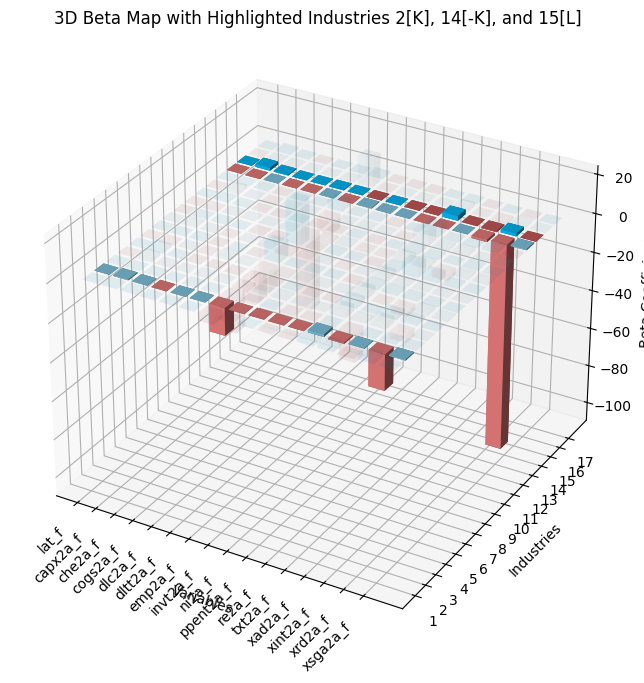

/tmp/ipython-input-8-176019324.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


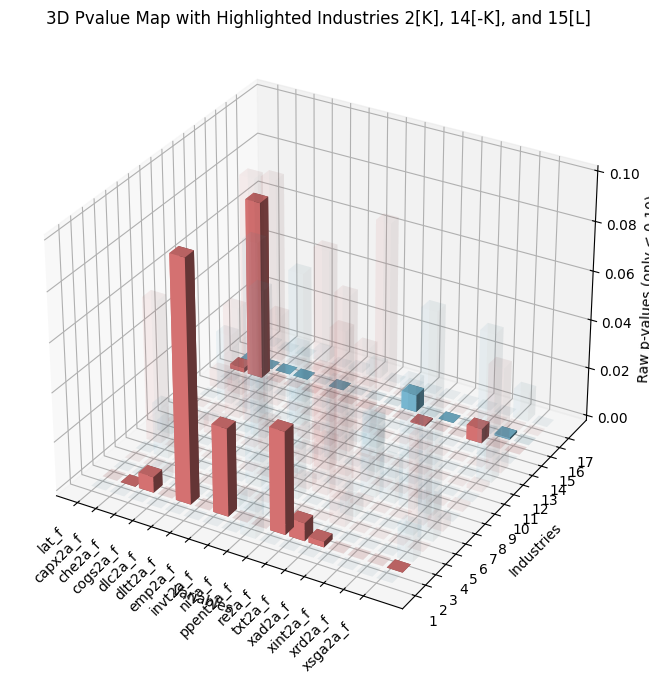

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

highlight_inds = [2, 14, 15]  # Industries to highlight

for ttt, ddd in [('beta', beta_df), ('pvalue', pval_df)]:
    # Drop 'const' column if exists
    data = ddd.drop(columns=['const']) if 'const' in ddd.columns else ddd.copy()

    industries = data.index.tolist()
    variables = data.columns.tolist()

    xpos, ypos = np.meshgrid(np.arange(len(variables)), np.arange(len(industries)))
    xpos = xpos.flatten()
    ypos = ypos.flatten()

    if ttt == 'beta':
        dz_raw = data.values.flatten()
        # Bars start at beta if negative, else 0
        zpos = np.minimum(dz_raw, 0)
        dz = np.abs(dz_raw)

        # Base colors by sign (positive=blue, negative=red) + zigzag shading
        base_colors = []
        for i, val in enumerate(dz_raw):
            is_even = (ypos[i] % 2 == 0)
            if val >= 0:
                base_colors.append('deepskyblue' if is_even else 'skyblue')
            else:
                base_colors.append('indianred' if is_even else 'lightcoral')

        alphas = []
        for i in range(len(ypos)):
            ind = industries[ypos[i]]
            if ind in highlight_inds:
                alpha = 1.0 if dz[i] > 0 else 0.1
            else:
                alpha = 0.05
            alphas.append(alpha)

        colors = [to_rgba(base_colors[i], alpha=alphas[i]) for i in range(len(base_colors))]

        zlabel = 'Beta Coefficients'

    elif ttt == 'pvalue':
        # Mask: only keep p-values less than 0.10, else 0 (no bar)
        pvals = data.values.flatten()
        dz = np.where(pvals < 0.10, pvals, 0)

        # Bars start at zero
        zpos = np.zeros_like(dz)

        # Zigzag colors for industries
        base_colors = ['skyblue' if ypos[i] % 2 == 0 else 'lightcoral' for i in range(len(ypos))]
        alphas = []
        for i in range(len(ypos)):
            ind = industries[ypos[i]]
            if ind in highlight_inds:
                alpha = 1.0 if dz[i] != 0 else 0.1
            else:
                alpha = 0.05
            alphas.append(alpha)

        colors = [to_rgba(base_colors[i], alpha=alphas[i]) for i in range(len(base_colors))]

        zlabel = 'Raw p-values (only < 0.10)'

    dx = dy = 0.8

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True)

    ax.set_xlabel('Variables')
    ax.set_ylabel('Industries')
    ax.set_zlabel(zlabel)
    ax.set_title(f'3D {ttt.capitalize()} Map with Highlighted Industries 2[K], 14[-K], and 15[L]')

    ax.set_xticks(np.arange(len(variables)))
    ax.set_xticklabels(variables, rotation=45, ha='right')

    ax.set_yticks(np.arange(len(industries)))
    ax.set_yticklabels(industries)

    plt.tight_layout()
    plt.show()


# 2. Manually Hard Coding

### 2-1. Shared Utility Functions

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t


In [16]:

def _add_intercept(X: np.ndarray) -> np.ndarray:
    """Add an intercept (bias) term to input features."""
    n = X.shape[0]
    return np.column_stack((np.ones(n), X))

def prepare_xy(df: pd.DataFrame, y_col: str, x_cols: list) -> tuple[np.ndarray, np.ndarray]:
    y = df[y_col].values
    X_raw = df[x_cols].values
    X = _add_intercept(X_raw)
    return y, X

def predict(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """Make predictions given input X and weights beta."""
    return X @ beta

def compute_residuals(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Compute residuals (y - ŷ)."""
    return y - y_pred

def compute_r_squared(y: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute R² (coefficient of determination)."""
    ss_total = np.sum((y - np.mean(y))**2)
    ss_resid = np.sum((y - y_pred)**2)
    return 1 - (ss_resid / ss_total)

def compute_ols_statistics(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> pd.DataFrame:
    """
    Compute standard errors, t-values, and p-values for OLS coefficients.
    Assumes intercept term is already included in X.
    """
    n, k = X.shape
    y_pred = predict(X, beta)
    residuals = compute_residuals(y, y_pred)
    df_resid = n - k

    rss = np.sum(residuals ** 2)
    sigma_squared = rss / df_resid

    XtX_inv = np.linalg.inv(X.T @ X)
    std_errors = np.sqrt(np.diag(sigma_squared * XtX_inv))
    t_values = beta.flatten() / std_errors # Flatten beta here
    p_values = 2 * (1 - t.cdf(np.abs(t_values), df=df_resid))

    return pd.DataFrame({
        'coef': beta.flatten(), # Flatten beta here
        'std_err': std_errors,
        't_value': t_values,
        'p_value': p_values
    })

### 2-2. OLS & NN : 1
1. OLS' Point of View: just use Exact Differentiation

2. NN's Point of View: Exact Differentiation -> Newton-Raphson method
- just like computer scientists, adapting to finite system, Computer!
- https://www.geeksforgeeks.org/engineering-mathematics/newton-raphson-method/


In [33]:
def manual_ols(df: pd.DataFrame, y_col: str, x_cols: list):
    y, X = prepare_xy(df, y_col, x_cols)

    # Closed-form solution
    XtX_inv = np.linalg.inv(X.T @ X)
    beta = XtX_inv @ X.T @ y

    y_pred = predict(X, beta)
    r_squared = compute_r_squared(y, y_pred)

    feature_names = ['const'] + x_cols
    stats_df = compute_ols_statistics(X, y, beta)
    stats_df.index = feature_names

    return stats_df, r_squared


def train_nn_track_path(df, y_col, x_cols, lr=1e-4, epochs=1000):
  y, X = prepare_xy(df, y_col, x_cols)
  y = y.reshape(-1, 1)
  n, k = X.shape

  beta = np.random.randn(k, 1) * 0.01
  path = [beta.flatten()]

  for _ in range(epochs):
      y_pred = X @ beta
      residuals = y - y_pred
      grad = (2 / n) * (X.T @ residuals)
      beta -= lr * grad
      path.append(beta.flatten())

  stats_df = compute_ols_statistics(X, y, beta)
  r_squared = compute_r_squared(y.flatten(), y_pred.flatten())

  feature_names = ['const'] + x_cols
  stats_df.index = feature_names

  return stats_df, r_squared, np.array(path)

stats_ols, r_squared_ols = manual_ols(df, y_col='logq_f', x_cols=x_cols)
stats_nn, r_squared_nn, path = train_nn_track_path(
    df, 'logq_f', x_cols, lr=1e-6, epochs=10000)

print('OLS R^2', r_squared_ols)
print('NN R^2', r_squared_nn)

OLS R^2 0.194127733791308
NN R^2 -0.00474451908567497


In [34]:
stats_ols.T

,const,lat_f,capx2a_f,che2a_f,cogs2a_f,dlc2a_f,dltt2a_f,emp2a_f,invt2a_f,ni2a_f,ppent2a_f,re2a_f,txt2a_f,xad2a_f,xint2a_f,xrd2a_f,xsga2a_f
coef,7.321973e-09,0.024075,4.437094e-01,0.264952,-0.003352,0.073010,0.112265,0.611439,-1.629942e-01,-0.016202,-1.191585e-01,0.001453,1.054952,0.049264,-0.142260,0.072965,0.141619
std_err,2.491764e-03,0.006584,5.453817e-02,0.013819,0.004445,0.017448,0.010826,0.252306,2.842179e-02,0.008991,1.494068e-02,0.001113,0.103035,0.053463,0.087319,0.022311,0.011691
t_value,2.938470e-06,3.656608,8.135758e+00,19.173691,-0.754120,4.184392,10.369863,2.423408,-5.734831e+00,-1.802055,-7.975438e+00,1.306192,10.238807,0.921456,-1.629213,3.270422,12.113676
p_value,9.999977e-01,0.000258,4.440892e-16,0.000000,0.450807,0.000029,0.000000,0.015405,1.024460e-08,0.071588,1.776357e-15,0.191538,0.000000,0.356850,0.103321,0.001080,0.000000


In [35]:
stats_nn.T

,const,lat_f,capx2a_f,che2a_f,cogs2a_f,dlc2a_f,dltt2a_f,emp2a_f,invt2a_f,ni2a_f,ppent2a_f,re2a_f,txt2a_f,xad2a_f,xint2a_f,xrd2a_f,xsga2a_f
coef,0.006871,0.013655,-0.008293,-0.011924,-0.007196,-0.002332,0.007619,0.005811,-0.002483,-0.001023,-0.005354,-0.002204,-0.013912,-0.006196,-0.002180,0.019860,-0.009704
std_err,0.002782,0.007351,0.060897,0.015430,0.004963,0.019483,0.012088,0.281722,0.031736,0.010039,0.016683,0.001242,0.115048,0.059697,0.097499,0.024912,0.013054
t_value,2.469729,1.857432,-0.136185,-0.772824,-1.449852,-0.119717,0.630320,0.020627,-0.078229,-0.101942,-0.320945,-1.773682,-0.120923,-0.103799,-0.022361,0.797202,-0.743380
p_value,0.013550,0.063299,0.891680,0.439657,0.147153,0.904711,0.528510,0.983544,0.937649,0.918806,0.748263,0.076167,0.903756,0.917332,0.982161,0.425366,0.457281


## Deep dive to weights of NN

In [48]:

def path_of_weights_update(path, x_cols, submsg=''):
  epochs = path.shape[0] - 1
  features = ['const'] + x_cols # Add 'const' for the intercept

  plt.figure(figsize=(8, 6))
  for i, feature in enumerate(features):
      plt.plot(range(epochs + 1), path[:, i], label=feature)

  plt.xlabel('Epochs')
  plt.ylabel('Weight Value')
  plt.title('Neural Network Weight Updates During Training: '+submsg)
  plt.legend()
  plt.grid(True)
  plt.show()

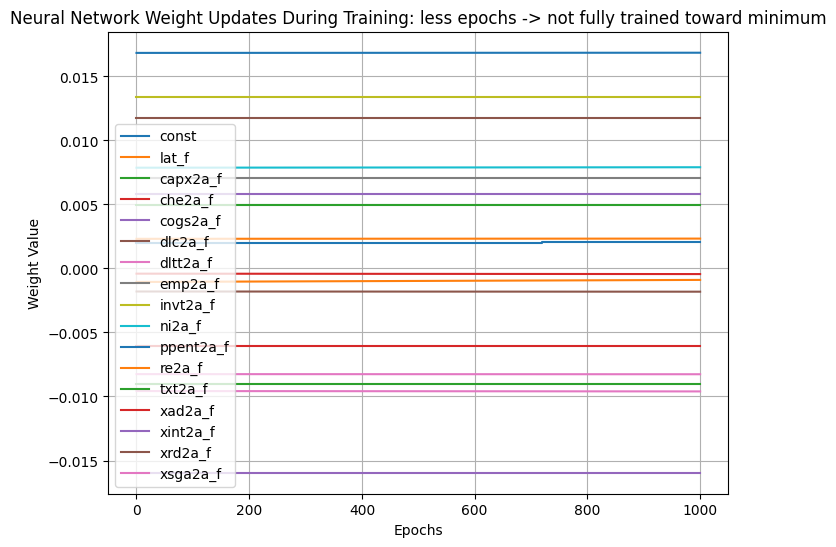

In [49]:
stats_nn, r_squared_nn, path = train_nn_track_path(
    df, 'logq_f', x_cols, lr=1e-6, epochs=1000)
path_of_weights_update(path, x_cols, submsg='less epochs -> cannot find ')


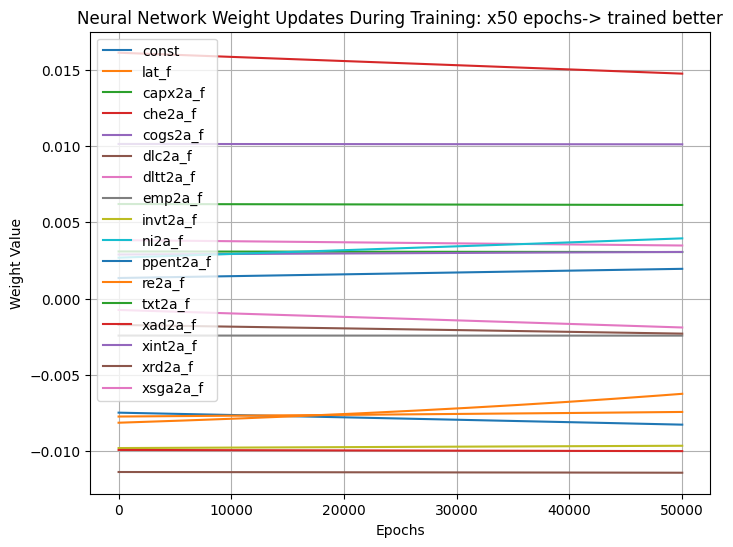

In [50]:
stats_nn, r_squared_nn, path = train_nn_track_path(
    df, 'logq_f', x_cols, lr=1e-6, epochs=50000)
path_of_weights_update(path, x_cols, submsg='x50 epochs-> trained better')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


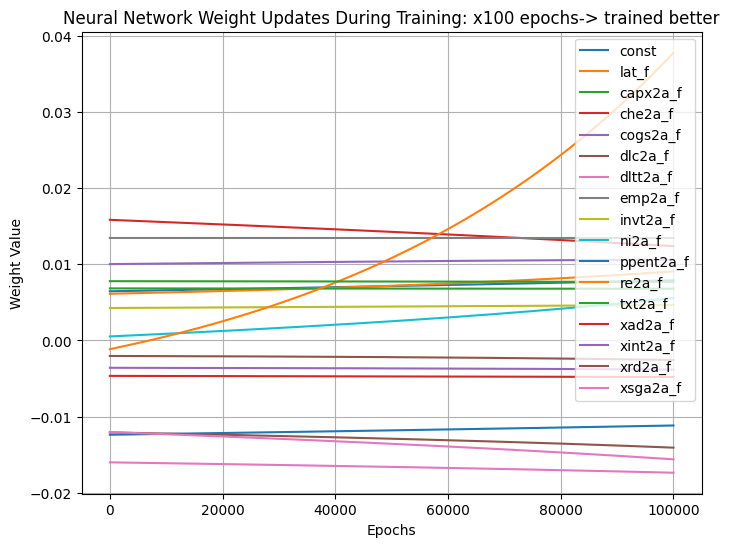

In [51]:
stats_nn, r_squared_nn, path = train_nn_track_path(
    df, 'logq_f', x_cols, lr=1e-6, epochs=100000)
path_of_weights_update(path, x_cols, submsg='x100 epochs')
